# Differentiation of HCN relative to neutral expectation

- For each city, test whether urban-rural divergence in HCN is greater than expected based on null distribution of randomly selected 4fold degenerate sites with a similar genetic architecture as HCN. Treating the HCN phenotype as if it were a single locus, the basic approach for this test is as follows:

1. Estimate urban and rural HCN frequencies from binomial regressions performed separately on each city
2. From these urban and rural HCN frequencies, calculate observed urban-rural differentiation in HCN using $F_{ST}$ formulas defined below
3. Generate a null distribution of $F_{ST}$ using genome-wide 4fold degenerate sites. Using 4fold site allele frequencies estimated separately in urban and rural habitats for each city, perform the following procedure:  
    **A.** Remove sites with fewer than 10 individuals contributing to frequency estimates so that considered sites have decent power to accurately estimate frequencies  
    **B.** Consider only sites with frequencies estimated for the same minor alleles in urban and rural habitats.  
    **C.** Randomly sample two 4fold sites and assign one site to be "_Ac_" and the other to be "_Li_"  
    **D.** Estimate "HCN" in each habitat separately using these "_Ac_" and "_Li_" frequencies. If $p_A$ is the frequency of the functional _Ac_ allele and $p_B$ the frequency of the functional "_Li_" allele, HCN can be estimated as $(2p_Aq_A + p_A^2) * (2p_Bq_B + p_B^2)$  
    **E.** Using the urban and rural "HCN" frequencies, estimate urban-rural differentiation in "HCN"  
    **F.** Repeat (C) to (E) 1000 times to generate null distribution of $F_{ST}$ using genome-wide 4fold sites  
    **G.** Calculate a P-value as the proportion of simulated $F_{ST}$  estimates greater or equal to the observed $F_{ST}$ value
    
### Fst estimation

I pulled the formulae here from Jakobsson _et. al._ 2013

I estimated $F_{ST}$ as:

$$F_{ST} = \frac{H_S - H_T}{1 - H_T}$$

where $H_T$ is homozygosity of the total population and $H_S$ is the mean homozygosity across subpopulations (Nei, 1973; Jakobsson _et. al._ 2013). Assume one polymorphic locus with two alleles (HCN+ and HCN- in our case) and $K$ subpopulations (2 in our case -- urban and rural). For $I$ distinct alleles, the frequency of allele $i$ in population $k$ is $p_{ki}$, and the mean frequency of allele $i$ across populations is $p_i = \frac{1}{K}\sum_{k=1}^{K}p_{ki}$. $H_T$ and $H_S$ can be calculates as follows:

$$H_T = \sum_{i=1}^{I}(\frac{1}{K}\sum_{k=1}^{K}p_{ki})^2$$

$$H_S = \frac{1}{K}\sum_{k=1}^{K}\sum_{i=1}^{I}p_{ki}^2$$



In [1]:
library(data.table)
library(tidyverse)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


In [2]:
# Load urban and rural 4fold allele frequencies for city in "path"
load_maf <- function(path){
    
    city <- basename(dirname(path))
    base = basename(path)
    
    if(grepl('_[r|u]_', base)){
        site <- str_extract(base, pattern = '(?<=_)[r|u]')
    }else{
        site <- 'cw'
    }    
    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
#         filter(nInd >= 10) %>%
        mutate(city = city, 
               site = site,
               pos = paste(chromo, position, sep = '_')) %>%
    dplyr::select(city, site, pos, everything(), -'pK-EM', -ref, -anc, -chromo, -position) %>%
    return(df)
}

# Find positions with allele frequency estimates in both habitats
intersect_positions <- function(df){
    
    df_out <- df %>%
        filter(pos %in% (df %>% 
                         group_split(site) %>% 
                         map(~pull(., pos)) %>% 
                         reduce(intersect)))
    return(df_out)
}

# Estimate HCN frequency from allele frequencies at two loci
estimate_hcn <- function(pA, pB){
    qA <- 1 - pA
    qB <- 1 - pB
    hcn <- (2*pA*qA + pA^2) * (2*pB*qB + pB^2)
    return(hcn)
}

# Estimate Fst from urban and rural allele frequencies
estimate_fst <- function(p_u, p_r){
    
    q_u <- 1 - p_u
    q_r <- 1 - p_r
    
    HT <- ((p_u + p_r) / 2)^2 + (( q_u + q_r) / 2)^2
    HS <- (p_u^2 + p_r^2 + q_u^2 + q_r^2) / 2
    
    fst <- (HS - HT) / (1 - HT)
    
    return(fst)
}

# Simulate null distribution by randomly sample 4fold sites "nreps" times
simulate_null <- function(df, nreps = 1000){
    
    city <- df %>% pull(city) %>% unique()
    stats_out <- c()
    
    for(i in 1:nreps){
        # Randomly sample 2 sites
        random_sites <- sample_n(df, size = 2)

        # Get mock "Ac" and "Li" allele frequencies in each habitat
        Ac_r <- random_sites[1, 'knownEM_r'] %>% pull()
        Li_r <- random_sites[2, 'knownEM_r'] %>% pull()
        Ac_u <- random_sites[1, 'knownEM_u'] %>% pull()
        Li_u <- random_sites[2, 'knownEM_u'] %>% pull()

        # Estimate mock HCN frequency in each habitat
        r_hcn <- estimate_hcn(Ac_r, Li_r)
        u_hcn <- estimate_hcn(Ac_u, Li_u)

        # Estimate differentiation stats as measure of differentiation in mock HCN
        fst <- estimate_fst(u_hcn, r_hcn)

        stats_out[i] <- fst
    }
    
    out <- tibble(city = city, rep = 1:nreps, fst = stats_out)
    return(out)
}

 # Function to estimate P-values by comparing observed value against null distribution
permutation_pval <- function(df){
    city <- df %>% pull(city) %>% unique()
    obs_val <- df %>% filter(is.na(rep)) %>% pull(fst)
    perm_val <- df %>% filter(!(is.na(rep))) %>% pull(fst)
    pval <- sum(abs(perm_val) >= abs(obs_val)) / length(perm_val)
    df_out <- data.frame(city = city, pval = pval)
    return(df_out)
}

In [6]:
# Load all 4fold allele frequencies as single dataframe
inpath <- '../../../results/angsd/afs/by_city/'
df_afs <- list.files(inpath, full.names = TRUE, recursive = TRUE, pattern = '*.mafs.gz') %>%
    map_dfr(., load_maf)

In [7]:
# Get sites common to urban and rural habitats, seaprately for each city
# Pivot data for easier random site selection
# Use only sites with same major and minor alleles
df_afs_inter <- df_afs %>%
    group_split(city) %>%
    map_dfr(., intersect_positions) %>%
    pivot_wider(names_from = site, values_from = c(knownEM, nInd, minor)) %>%
    filter(minor_u == minor_r) %>% 
    filter(minor_u == minor_cw)
head(df_afs_inter)

city,pos,major,knownEM_cw,knownEM_r,knownEM_u,nInd_cw,nInd_r,nInd_u,minor_cw,minor_r,minor_u
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
Albuquerque,CM019101.1_17063,A,0.569058,0.522677,0.633789,23,13,10,C,C,C
Albuquerque,CM019101.1_17462,T,0.151437,0.144811,0.157838,26,13,13,A,A,A
Albuquerque,CM019101.1_19481,C,0.703291,0.741929,0.661749,26,13,13,A,A,A
Albuquerque,CM019101.1_19520,G,0.775735,0.746196,0.806513,26,13,13,A,A,A
Albuquerque,CM019101.1_19553,A,0.723670,0.638462,0.828019,22,12,10,T,T,T
Albuquerque,CM019101.1_47203,C,0.919419,0.880891,0.965221,42,23,19,G,G,G


In [8]:
# Number of sites considered for each city
df_afs_inter %>% 
    group_by(city) %>% 
    summarise(nSites = n())

city,nSites
<chr>,<int>
Albuquerque,357886
Antwerp,369318
Armidale,340265
Athens,342773
Bogota,212209
Buenos_Aires,313963
Calgary,395535
Canberra,180346
Cape_Town,321954


In [9]:
# Load in sample sheet
# Load binomial regression model summaries and predict urban and rural HCN
# Load in mean HCN frequencies by city and mer with urban and rural HCN estimates
sample_sheet <- suppressMessages(read_delim('../resources/glue_pc_sampleSheet.txt', delim = '\t'))
obs_hcnFst <- suppressMessages(read_csv('../../phenotypic-analyses/analysis/supplementary-tables/allCities_logisticReg_coefs.csv')) %>% 
    filter(city %in% sample_sheet$city) %>% 
    mutate(hcn_u = exp(yint_Dist + betaLog_Dist*0) / (1 + (exp(yint_Dist + betaLog_Dist*0))),
           hcn_r = exp(yint_Dist + betaLog_Dist*1) / (1 + (exp(yint_Dist + betaLog_Dist*1)))) %>% 
    mutate(sig = ifelse(pvalLog_Dist < 0.05, 'Yes', 'No')) %>% 
    mutate(fst = round(estimate_fst(hcn_u, hcn_r), 3)) %>% 
    dplyr::select(city, sig, hcn_u, hcn_r, fst)
head(obs_hcnFst)

city,sig,hcn_u,hcn_r,fst
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Albuquerque,Yes,0.30470333,0.1592258,0.030
Antwerp,Yes,0.09673856,0.4790123,0.178
Armidale,Yes,0.55354390,0.8457958,0.102
Athens,Yes,0.35755317,0.7269097,0.137
Bogota,Yes,0.29629576,0.4935004,0.041
Buenos_Aires,No,0.75565431,0.7584133,0.000


In [10]:
# Get null distributions of fst separately for each city
set.seed(42)
nulls <- df_afs_inter %>% 
    group_split(city) %>% 
    map_dfr(~simulate_null(., nreps = 1000))

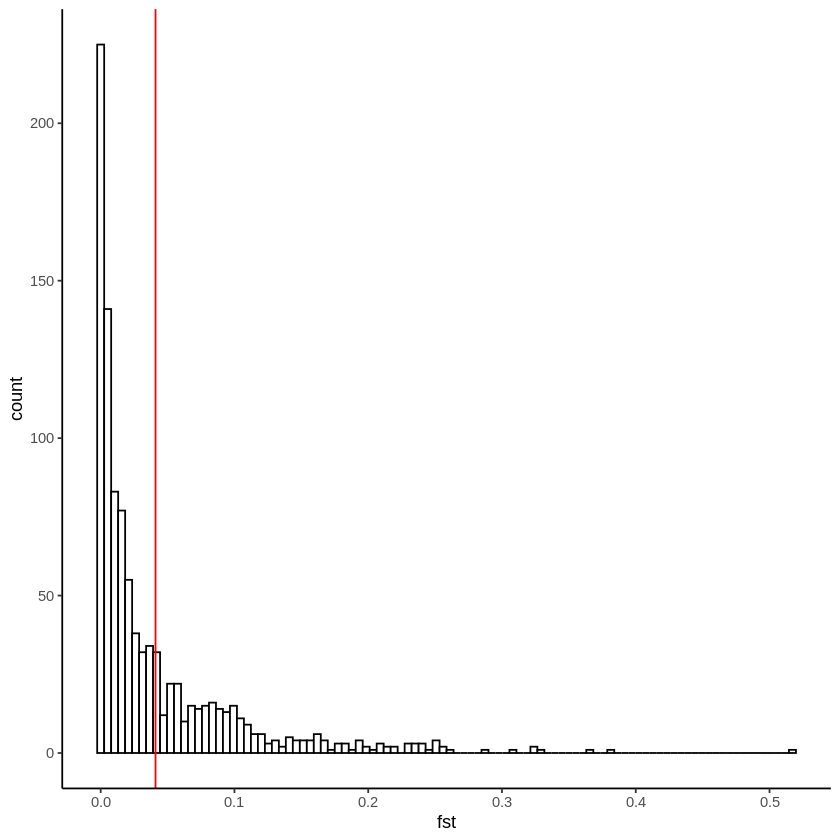

In [11]:
# Example permutation test
nulls %>% filter(city == 'Bogota') %>% 
    ggplot(aes(x = fst)) +
    geom_histogram(bins = 100, color = 'black', fill = 'white') +
    geom_vline(xintercept = obs_hcnFst %>% filter(city == 'Bogota') %>% pull(fst), color = 'red') +
    theme_classic()

In [12]:
# Conbine observed and permutes Fst into single dataframe for permutation test
combine_stats_sf <- obs_hcnFst %>% 
    dplyr::select(city, fst) %>% 
    bind_rows(nulls)

In [13]:
# Perform permutation test, separately for each city
perm_pval_df <- combine_stats_sf %>% 
    group_split(city) %>% 
    purrr::map_dfr(., permutation_pval) %>% 
    left_join(obs_hcnFst %>% dplyr::select(city, sig)) %>% 
    mutate(sig_perm = ifelse(pval < 0.05, 'Yes', 'No')) %>% 
    mutate(match_expect = ifelse(sig == sig_perm, 'Yes', 'No'))

Joining, by = "city"


In [14]:
perm_pval_df

city,pval,sig,sig_perm,match_expect
<chr>,<dbl>,<chr>,<chr>,<chr>
Albuquerque,0.222,Yes,No,No
Antwerp,0.010,Yes,Yes,Yes
Armidale,0.048,Yes,Yes,Yes
Athens,0.033,Yes,Yes,Yes
Bogota,0.305,Yes,No,No
Buenos_Aires,1.000,No,No,Yes
Calgary,0.119,Yes,No,No
Canberra,1.000,No,No,Yes
Cape_Town,0.295,No,No,Yes


In [15]:
# Chi-square test
chisq_table <- table(perm_pval_df$sig, perm_pval_df$sig_perm)
print(chisq_table)
chisq.test(chisq_table, correct = FALSE)

     
      No Yes
  No   9   0
  Yes  8   9


Warning message in chisq.test(chisq_table, correct = FALSE):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  chisq_table
X-squared = 7.2872, df = 1, p-value = 0.006945
